In [1]:
import string

import numpy as np
from keras.models import load_model
from matplotlib import pyplot as plt
%matplotlib inline

from data.generate_data import generate_yolo_train_data


Using TensorFlow backend.


In [2]:
chars_list = list(string.ascii_letters)
chars_list.extend(list(string.digits))
n_classes = len(chars_list)

We trained a classifier to recognize characters.

Prediction: B, ground truth: B


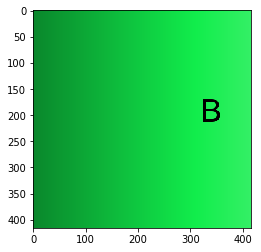

Prediction: d, ground truth: d


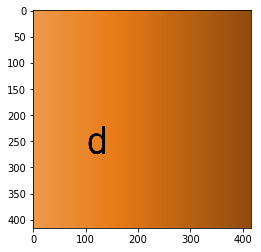

Prediction: T, ground truth: T


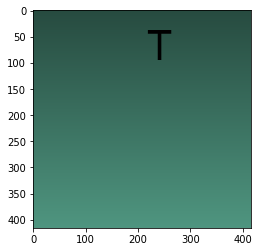

Prediction: b, ground truth: p


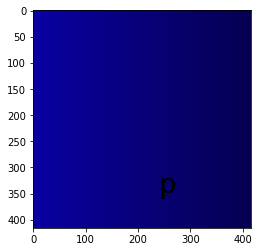

Prediction: 9, ground truth: 9


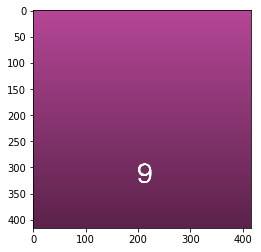

In [4]:
from data.generate_data import generate_train_data

data_generator = generate_train_data(5, chars_list, ['arial'], (50, 100)) # create a generator
test_x, test_y = next(data_generator) # get 5 images from the generator

classifier = load_model('model_all_chars.h5') # we load the model
preds = classifier.predict(test_x) # we predict from the image
preds = np.argmax(preds, axis=1) # choose the highest character index
test_y = np.argmax(test_y, axis=1)


for image, pred, y in zip(test_x, preds, test_y):
    print('Prediction: {}, ground truth: {}'.format(chars_list[pred], chars_list[y]))
    plt.imshow(image)
    plt.show()

During training we use Keras' fit_generator. The generator generates an image with one ore more characters on it and the 3 corresponding output tensors to it.

In [5]:

batch_size = 5
cell_sizes = [16, 8, 4]
anchor_boxes = [(64, 64), (32, 32), (16, 16)]

We set the parameters: batch size, pixel size of grids we predict in, anchor box sizes we use at different scales, list of chars we want to generate, font and size of the chars and the size of the image.

In [6]:
train_data_generator = generate_yolo_train_data(batch_size, cell_sizes,
                                                anchor_boxes, chars_list, ['arial'], (50, 100), (416,416))
images, out_tensors = next(train_data_generator)

It generates images:

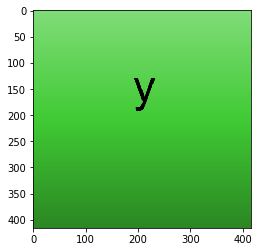

In [7]:
plt.imshow(images[0])
plt.show()

And corresponding output tensors:

Grid size in the 1st scale: 26 by 26
Grid size in the 2nd scale: 52 by 52
Grid size in the 3rd scale: 104 by 104

Predicted values per cell: 68


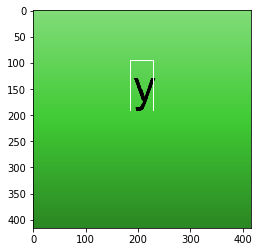

In [9]:
from data.generate_data import draw_bounding_boxes

out1, out2, out3 = out_tensors
print('Grid size in the 1st scale: {} by {}'.format(out1[0].shape[1], out1[0].shape[0]))
print('Grid size in the 2nd scale: {} by {}'.format(out2[0].shape[1], out2[0].shape[0]))
print('Grid size in the 3rd scale: {} by {}'.format(out3[0].shape[1], out3[0].shape[0]))

print('\nPredicted values per cell: {}'.format(out1[0].shape[2]))

for i in range(len(out_tensors)):
    img_pred = out_tensors[i][0]
    confidence = img_pred[..., 0]
    if (confidence==1).any():
        index = np.unravel_index(np.argmax(confidence, axis=None), confidence.shape)
        pred_data = img_pred[index]
        x = index[1]*cell_sizes[i] + pred_data[1]
        y = index[0]*cell_sizes[i] + pred_data[2]
        w = pred_data[3]*anchor_boxes[i][0]
        h = pred_data[4]*anchor_boxes[i][1]
        image_with_bbox = draw_bounding_boxes(images[0]*255, np.array([[x,y,w,h]]))
        image_with_bbox = np.array(image_with_bbox)/255
        plt.imshow(image_with_bbox)
        plt.show()

